**Demo for using NASA NEX DCP30 data over thredds server.**

Done by script (user can modify, but should not be necessary)

1. Initialise server path, variable names, scenarios
2. Get model names
3. Initialize variable, scenario and model dictionary
4. Suggest dictionary kind of data types

User should
1. Change the selection of models
2. --"--                   area
3. --"--                   time range
4. --"--                   scenarios
5. Data analysis, based on example function *mean_of_subset*, if necessary
6. Plotting data
7. etc

Main data variables:

**full_model_list** -- python dictionary with subdictionary hierarchy of: variable, scenario, model. Derived with function *fetch_model_names*
                   Example: full_model_list['pr']['rcp26']['BNU-ESM_pr']=[ 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/rcp26/r1i1p1/BNU-ESM_pr.ncml']

**model_data** -- python dictionary: variable, scenario, model, [variable, url] -- data in full dimensions

**model_mean** -- example of averaging over models and spatial domain

Coordinate selection:

**tim1, tim2** -- time bounds for *historical* experiments. Numbers (units?)
**timrcp1, timrcp2 ** -- time bound for *scenario* experiments. 
**lon1,lon2,lat1,lat2** -- geographical boundaries, by data points (not coordinate values)

Coordinate values:

** tim, tim_full ** -- values of actual historical time slice, computed in units ?

** timrcp, timrcp_full ** -- values of actual scenario time slice

** lat, lon ** -- values of actual coordinates, computed, in degrees

In [393]:
## User configurables
## TDS base URL
tds_url_base='http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd'
## Scenarios 
scenarios=['historical','rcp26','rcp45','rcp60','rcp85']
## Realisation?
url_step2='r1i1p1'
## Available variables
variables=['tasmin','tasmax','pr']

## Coordinate limits, if too large then download fails
tim1=0
tim2=100
timrcp1=0
timrcp2=200
lon1=1000
lon2=1001
lat1=1200
lat2=1201


In [394]:
## general imports
%matplotlib inline
import numpy as np
import time
import re
import urllib2
from pydap.client import open_url
import matplotlib.pyplot as plt



In [462]:
def fetch_model_names(scenario,variable):
    """
    Select models from the server. 
    Not all models are available for all scenarios"""
    xmlpath="/".join([tds_url_base,scenario,'r1i1p1','catalog.xml'])
    #print(xmlpath)
    abxml=urllib2.urlopen(xmlpath)
    prog=re.compile("name=\"[a-zA-Z0-9\-\_]+_{0}.ncml\"".format(variable))
    mudell={}
        
    for i in abxml.readlines():
        a=prog.search(i)
        #print(i)
        if a:
            # no need to really initialise the opendap endpoint
            mudell[a.group().split('=')[1].split('.')[0][1:]]=tds_url_base+"/"+scenario+"/r1i1p1/"+a.group().split('=')[1].split('.')[0][1:]+'.ncml'
    return mudell

## Compute mean subset of models, careful, takes time
def get_subset(invars,scenarios,models):
    """Fetch actual data according to vars and scenarios"""
    model_data={}
    for v in invars:
        #print('v',v)
        model_data[v]={}
        for sc in scenarios:
            #print('sc',sc)
            model_data[v][sc]={}
            for model in models:
                m=model
                model_data[v][sc][m]={'url':open_url(full_model_list[v][sc][m+'_'+v])}
                prtemp=model_data[v][sc][m]['url'][m+'_'+v][m+'_'+v]
                if sc=='historical':
                    model_data[v][sc][m][v]=prtemp[tim1:tim2,lat1:lat2,lon1:lon2]
                else:
                    model_data[v][sc][m][v]=prtemp[timrcp1:timrcp2,lat1:lat2,lon1:lon2]
    return model_data
                
def mean_of_subset(model_data):
    """Compute mean over spatial domain and models"""
    sum_mean={}
    ##aa={}
    for v in model_data:
        print(v)
        ##aa[v]={}
        sum_mean[v]={}
        for sc in model_data[v]:
            print(sc)
            ##aa[v][sc]=[model_data[v][sc][j][v] for j in model_data[v][sc]]
            aab=[model_data[v][sc][j][v] for j in model_data[v][sc]]
            if sc=='historical':
                sum_mean[v][sc]=np.zeros(tim2-tim1)
            else:
                sum_mean[v][sc]=np.zeros(timrcp2-timrcp1)
            for i in aab:
                #print(len(i))
                sum_mean[v][sc]=sum_mean[v][sc]+np.mean(np.mean(i,axis=1),axis=1)
            sum_mean[v][sc]=sum_mean[v][sc]/len(aab)
    return sum_mean

In [454]:
def fetch_model_list(scenario):
    """Get models, which are available for particular scenario as pydab objects (slow for many models)"""
    xmlpath="/".join([tds_url_base,scenario,'r1i1p1','catalog.xml'])
    #print(xmlpath)
    abxml=urllib2.urlopen(xmlpath)
    prog=re.compile("name=\"[a-zA-Z0-9\-\_]+_pr.ncml\"")
    mudell={}
        
    for i in abxml.readlines():
        a=prog.search(i)
        #print(i)
        if a:
            # no need to really initialise the opendap endpoint
            mudell[a.group().split('=')[1].split('.')[0][1:]]=open_url(tds_url_base+"/"+scenario+"/r1i1p1/"+a.group().split('=')[1].split('.')[0][1:]+'.ncml')
    return mudell

In [455]:
full_model_list={}
for v in variables:
    full_model_list[v]={}
    for i in scenarios:
        full_model_list[v][i]=fetch_model_names(i,v)

In [456]:
full_model_list['tasmax']['historical']

{'ACCESS1-0_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/historical/r1i1p1/ACCESS1-0_tasmax.ncml',
 'BNU-ESM_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/historical/r1i1p1/BNU-ESM_tasmax.ncml',
 'CCSM4_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/historical/r1i1p1/CCSM4_tasmax.ncml',
 'CESM1-BGC_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/historical/r1i1p1/CESM1-BGC_tasmax.ncml',
 'CESM1-CAM5_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/historical/r1i1p1/CESM1-CAM5_tasmax.ncml',
 'CMCC-CM_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/historical/r1i1p1/CMCC-CM_tasmax.ncml',
 'CNRM-CM5_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcsd/historical/r1i1p1/CNRM-CM5_tasmax.ncml',
 'CSIRO-Mk3-6-0_tasmax': 'http://dataserver.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/bcs

In [355]:
## Fetch any single model_scenario data

In [429]:
uioi=open_url(full_model_list['pr']['historical']['ACCESS1-0'])

In [430]:
## simplify name
pr1=uioi['ACCESS1-0']['ACCESS1-0']

In [431]:
## fetch coordinates, should be the same for rcp-s and all models
##lon=np.copy(uioi['lon'][1000:1050])
tim_full=np.copy(uioi['time'][:])
tim=np.copy(uioi['time'][tim1:tim2])

In [432]:
lat=np.copy(uioi['lat'][lat1:lat2])
lon=np.copy(uioi['lon'][lon1:lon2])

In [433]:
## historical and scenarios should have different time values
uioi2=open_url(full_model_list['pr']['rcp45']['ACCESS1-0'])
#timrcp_full=np.copy(uioi2['time'][:])
timrcp=np.copy(uioi2['time'][timrcp1:timrcp2])

In [467]:
##example of fetching real data
model_data=get_subset(['pr'],['historical','rcp45'],['CCSM4','MIROC-ESM-CHEM','MRI-CGCM3','bcc-csm1-1'])

In [463]:
model_data2=get_subset(['tasmin','pr'],['historical'],['CCSM4'])

In [468]:
model_data2['tasmin']['historical']['CCSM4']

{'tasmin': array([[[ 269.70217896]],
 
        [[ 271.93383789]],
 
        [[ 273.30435181]],
 
        [[ 278.62536621]],
 
        [[ 281.84857178]],
 
        [[ 285.49667358]],
 
        [[ 288.37472534]],
 
        [[ 286.6862793 ]],
 
        [[ 283.88290405]],
 
        [[ 277.76992798]],
 
        [[ 276.01904297]],
 
        [[ 272.86526489]],
 
        [[ 271.79873657]],
 
        [[ 273.94396973]],
 
        [[ 271.93453979]],
 
        [[ 276.69155884]],
 
        [[ 281.38842773]],
 
        [[ 284.71652222]],
 
        [[ 288.37310791]],
 
        [[ 288.50985718]],
 
        [[ 286.47259521]],
 
        [[ 278.49789429]],
 
        [[ 275.37185669]],
 
        [[ 272.38238525]],
 
        [[ 271.18106079]],
 
        [[ 274.07540894]],
 
        [[ 274.7855835 ]],
 
        [[ 277.82974243]],
 
        [[ 279.3651123 ]],
 
        [[ 282.94436646]],
 
        [[ 290.0279541 ]],
 
        [[ 289.66879272]],
 
        [[ 286.64654541]],
 
        [[ 278.23049927]],
 
    

KeyError: 'rcp_45'

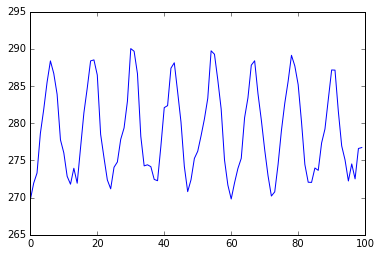

In [476]:
plt.plot(model_data2['tasmin']['historical']['CCSM4']['tasmin'][:,0,0])

In [470]:
len(model_data['pr']['rcp45']['MRI-CGCM3']['pr'])

200

In [471]:
model_mean=mean_of_subset(model_data)

pr
rcp45
historical


In [472]:
model_mean['pr']['rcp45'].shape

(200,)

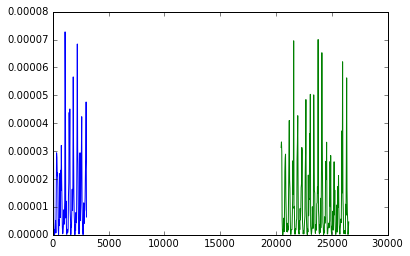

In [473]:
plt.plot(tim[tim1:tim2],model_mean['pr']['historical'])
plt.plot(timrcp[timrcp1:timrcp2],model_mean['pr']['rcp45'])